## Replication of http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture16.pdf, slide 11

**Result**: behavior is only present after network has been trained

This notebook is currently not runnable due to changes in utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from resnet import *
from vgg import *

from utils import *

gpu_dtype = torch.cuda.FloatTensor

In [33]:
model = ResNet18()
# model = VGG('VGG11')
model.cuda()

for param in model.parameters():
    param.requires_grad = False
print(get_param_count(model))

loader_train, loader_val, loader_test = get_cifar_loaders()

11173962
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Interpolation before training

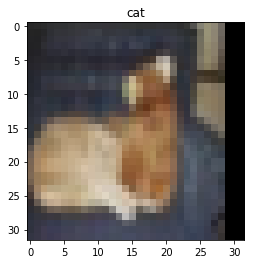

In [3]:
images, labels = iter(loader_train).next()
i = 17
image, label = images[i, np.newaxis], labels[i]

img = image.cuda()
img_var = Variable(img, requires_grad=True)
interpolator = Interpolator(model, img_var)

imshow(img.cpu().numpy(), label)

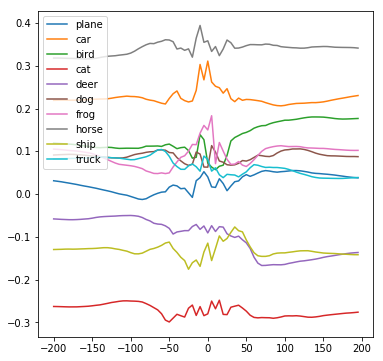

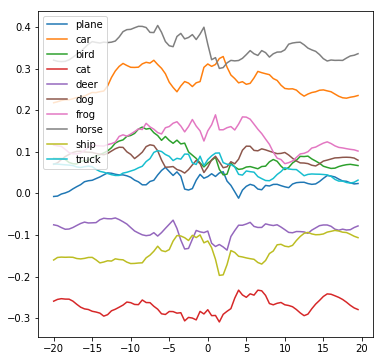

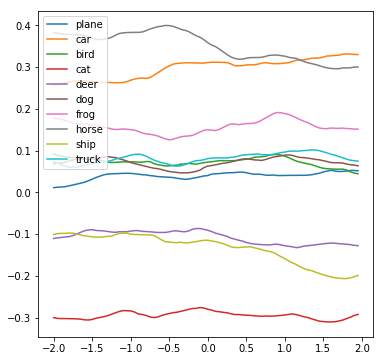

In [4]:
# random direction
g = torch.FloatTensor(np.random.randn(32, 32))
g = g / g.norm()

interpolator.plot(g, np.arange(-200, 200, 5))
interpolator.plot(g, np.arange(-20, 20, .5))
interpolator.plot(g, np.arange(-2, 2, .05))

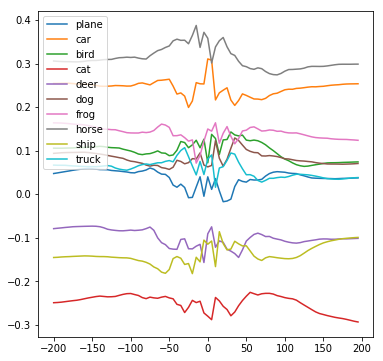

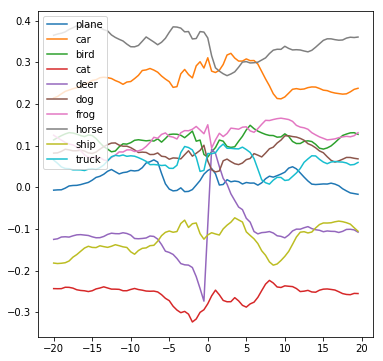

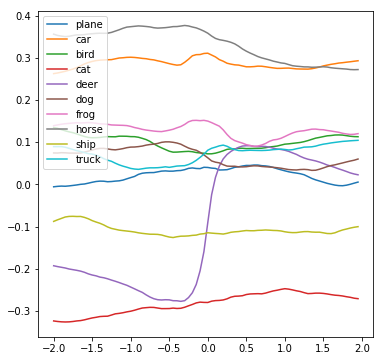

In [5]:
# find adversarial direction
scores = model(img_var)
objective = scores.squeeze()[4]
objective.backward()
g = img_var.grad.data.clone()
img_var.grad.zero_()
g = g / g.norm()

interpolator.plot(g, np.arange(-200, 200, 5))
interpolator.plot(g, np.arange(-20, 20, .5))
interpolator.plot(g, np.arange(-2, 2, .05))

## Train the network (resnet18)

In [34]:
for p in model.parameters():
    p.requires_grad = True
trainer = Trainer(model, loader_train, loader_val)
trainer.optimizer = optim.SGD(trainer.model.parameters(), lr=0.08,
                              momentum=0.9, weight_decay=1e-3)
trainer.train_schedule([10, 5, 2])

Training for 10 epochs with learning rate 0.080000
Starting epoch 1 / 10
loss = 1.3693
Got 2405 / 5000 correct (48.10)
Starting epoch 2 / 10
loss = 1.0313
Got 2918 / 5000 correct (58.36)
Starting epoch 3 / 10
loss = 0.9890
Got 3457 / 5000 correct (69.14)
Starting epoch 4 / 10
loss = 0.8380
Got 3463 / 5000 correct (69.26)
Starting epoch 5 / 10
loss = 0.9513
Got 3339 / 5000 correct (66.78)
Starting epoch 6 / 10
loss = 0.7501
Got 3709 / 5000 correct (74.18)
Starting epoch 7 / 10
loss = 0.8245
Got 3410 / 5000 correct (68.20)
Starting epoch 8 / 10
loss = 0.7386
Got 3716 / 5000 correct (74.32)
Starting epoch 9 / 10
loss = 0.5985
Got 3452 / 5000 correct (69.04)
Starting epoch 10 / 10
loss = 0.7092
Got 3473 / 5000 correct (69.46)
Training for 5 epochs with learning rate 0.008000
Starting epoch 1 / 5
loss = 0.3519
Got 4413 / 5000 correct (88.26)
Starting epoch 2 / 5
loss = 0.3624
Got 4452 / 5000 correct (89.04)
Starting epoch 3 / 5
loss = 0.2906
Got 4467 / 5000 correct (89.34)
Starting epoch 4 

In [35]:
trainer.check_accuracy(loader_test)
trainer.save_checkpoint()

Got 9065 / 10000 correct (90.65)


In [141]:
from importlib import reload
import utils
reload(utils)
from utils import *
import resnet
reload(resnet)
from resnet import *

In [142]:
model = ResNet18().cuda()
trainer = Trainer(model, loader_train, loader_val)
trainer.check_accuracy(loader_test)
trainer.load_checkpoint('resnet.pth.tar')
trainer.check_accuracy(loader_test)

Got 1000 / 10000 correct (10.00)
Got 9065 / 10000 correct (90.65)


# Run the same experiments on trained network

Now that's what I call generalization

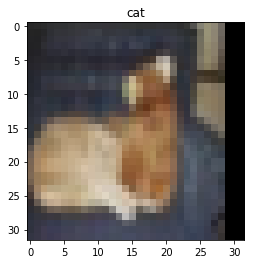

cat
cat


In [144]:
for param in model.parameters():
    param.requires_grad = False

imshow(image, label)
print(CIFAR_CLASSES[label])
print(CIFAR_CLASSES[model(img_var).max(1)[1].data[0]])

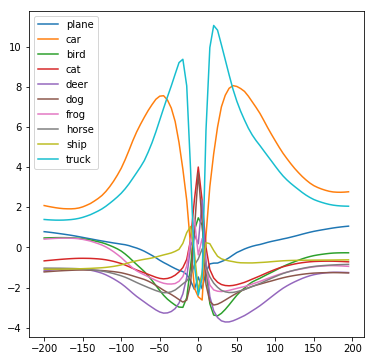

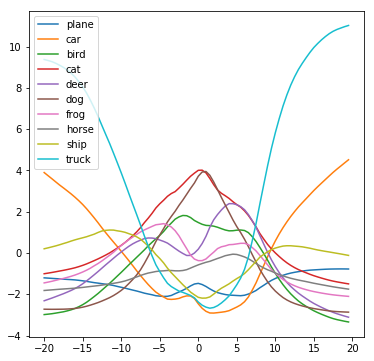

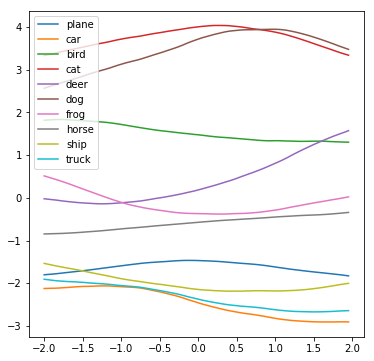

In [39]:
# random direction
g = torch.FloatTensor(np.random.randn(3, 32, 32))
g = g / g.norm()

interpolator.plot(g, np.arange(-200, 200, 5))
interpolator.plot(g, np.arange(-20, 20, .5))
interpolator.plot(g, np.arange(-2, 2, .05))

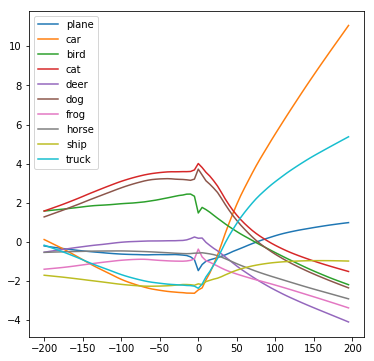

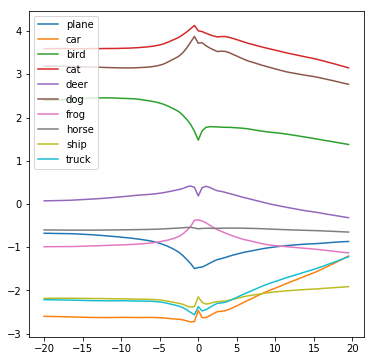

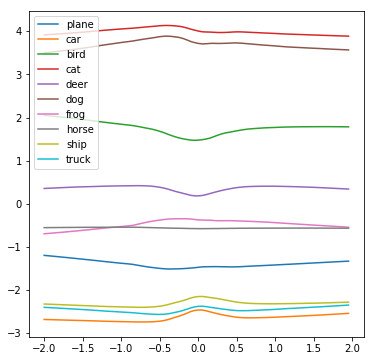

In [130]:
# random direction
g = torch.FloatTensor(np.zeros((3, 32, 32)))
g[1, 30, 12] = 1
g = g / g.norm()

interpolator.plot(g, np.arange(-200, 200, 5))
interpolator.plot(g, np.arange(-20, 20, .5))
interpolator.plot(g, np.arange(-2, 2, .05))

In [88]:
def make_img(g):
    return (img.cpu() + g.cpu()).clamp(min=-1, max=1)

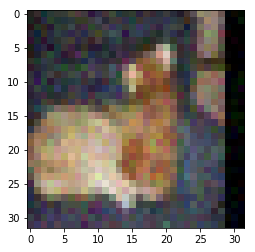

In [89]:
imshow(make_img(5*g))

In [100]:
scores = model(Variable(make_img(8*g).cuda()))
CIFAR_CLASSES[scores.max(1)[1].data[0]]

'deer'

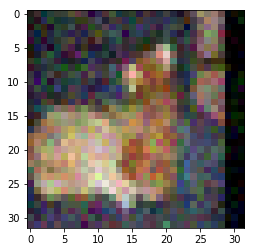

In [101]:
imshow(make_img(8*g))

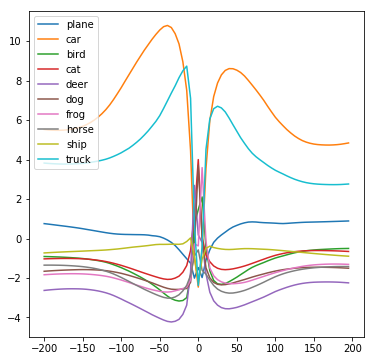

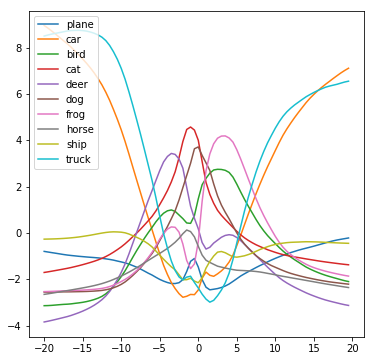

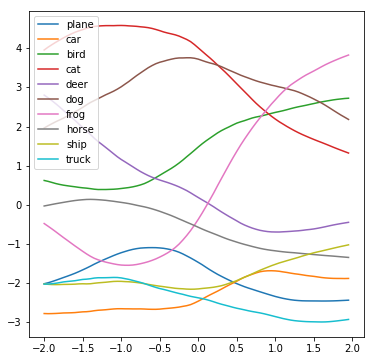

In [146]:
# find adversarial direction
scores = model(img_var)
objective = scores.squeeze()[6]
objective.backward()
g_adv = img_var.grad.data.clone()
img_var.grad.zero_()
g_adv = g_adv / g_adv.abs()
g_adv = g_adv / g_adv.norm()

interpolator.plot(g_adv, np.arange(-200, 200, 5))
interpolator.plot(g_adv, np.arange(-20, 20, .5))
interpolator.plot(g_adv, np.arange(-2, 2, .05))

In [147]:
fake = img_var.clone()
fake[0, 1, 30, 19] = 50
scores = model(fake)

frog


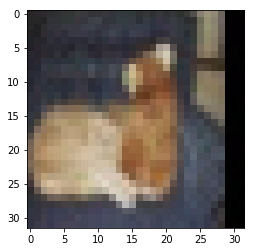

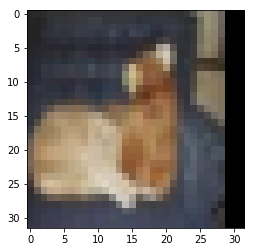

In [164]:
fake_adv = make_img(1*g_adv)
scores = model(Variable(fake_adv.cuda()))
print(CIFAR_CLASSES[scores.max(1)[1].data[0]])
# fake_pixel0 = 

imshow(fake_adv)
imshow(img)